# Compare the LSST magnitudes I calculate to those from TRILEGAL

Should I use Kurucz atmospheres?

https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/resBasedDoc/kuruczModels.html

https://pysynphot.readthedocs.io/en/latest/spectrum.html

In [1]:
import sys
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code/vespa_update')
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from newLSSTEBWorker import LSSTEBWorker
from SED import SED
import pandas as pd
import numpy as np
from astropy import units, constants 
from matplotlib import pyplot as plt
%matplotlib inline

#%load_ext autoreload
#%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


*Read in a TRILEGAL field*

In [2]:
filename = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/testing/TRILEGAL/grid/TRILEGAL_model_fID390.h5'
df = pd.read_hdf(filename)
#dist = 10.**(df['m-M0'].values/5.) * 10.# *u.parsec

dist = 10.**( (df['m-M0'].values + 5)/5.) #pc
logDist = np.log10(dist/1000.) #log(d [kpc])
logR = 2.*(0.25*df['logL'] - df['logTe'] + 3.762) #taken from my N-body notes to get logT <-- from Jarrod Hurley

df['logR'] = logR
df['logDist'] = logDist

print(df)

        Gc  logAge  [M/H]    m_ini   logL  logTe   logg  m-M0     Av  m2/m1  \
0        1    6.65  -0.35  1.75924  1.098  3.967  4.398  13.9  5.662    0.0   
1        1    6.65  -0.33  9.22456  3.651  4.390  4.258  13.9  5.905    0.0   
2        1    6.65  -0.31  3.03816  1.989  4.129  4.395  13.3  4.950    0.0   
3        1    6.65  -0.29  1.16075  0.226  3.811  4.466  12.6  4.327    0.0   
4        1    6.65  -0.27  2.24251  1.489  4.036  4.391  13.4  4.464    0.0   
5        1    6.65  -0.23  1.52547  0.801  3.895  4.348  11.7  3.481    0.0   
6        1    6.65  -0.21  1.53534  0.807  3.895  4.344  11.3  2.763    0.0   
7        1    6.65  -0.19  0.70111 -0.818  3.662  4.695  11.4  2.864    0.0   
8        1    6.65  -0.19  1.59277  0.873  3.907  4.340  13.5  4.244    0.0   
9        1    6.65  -0.19  2.36859  1.558  4.042  4.369  14.6  5.942    0.0   
10       1    6.65  -0.17  0.99625 -0.120  3.757  4.532   9.0  1.113    0.0   
11       1    6.65  -0.17  0.67534 -0.893  3.653  4.

*Create an EB in my code*

In [3]:
worker = LSSTEBWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.useOpSimDates = False
np.random.seed()

In [4]:
#dummy class so that I can use my EclipsingBinary code
class OpSim(object):
    def __init__(self, N):
        self.RA = np.zeros(N)
        self.Dec = np.zeros(N)

In [5]:
diff = {}
diff['mbol'] = []
diff['Teff'] = []
diff['MH'] = []
diff['Av'] = []
diff['Ldiff'] = []
diff['u'] = []
diff['g'] = []
diff['r'] = []
diff['i'] = []
diff['z'] = []
diff['y'] = []

N = 100
worker.OpSim = OpSim(N)

for i in range(N):
    print(i)
    if (df['logg'][i] > 3):
        L1 = 10.**df['logL'][i]
        L2 = 1e-20
        r1 = 10.**df['logR'][i]
        r2 = 1e-20
        T1 = 10.**df['logTe'][i]
        T2 = 5000.
        g1 = df['logg'][i]
        g2 = 4.
        dist = 10.**df['logDist'][i]
        Av = df['Av'][i]
        M_H = df['[M/H]'][i]

        line = [1., 1., 1., 0., r1, r2, L1, L2, 1., 1., 1., dist, 0., 0., 0., Av, M_H, T1, T2, g1, g2]
        print(line)

        EB = worker.getEB(line, i)

    #     print(EB.T1, 10.**df['logTe'][i])
    #     print(EB.Mbol, df['mbol'][i] - df['m-M0'][i])

    #     print(EB.appMagMean)
    #     print(dfmags.iloc[i])

        diff['mbol'].append(df['mbol'][i])
        diff['Teff'].append(EB.T1)
        diff['Av'].append(Av)
        diff['MH'].append(M_H)
    #     diff['Ldiff'].append(L1 - EB.Ltest)
        diff['u'].append(df['u_mag'][i] - EB.appMagMean['u_'])
        diff['g'].append(df['g_mag'][i] - EB.appMagMean['g_'])
        diff['r'].append(df['r_mag'][i] - EB.appMagMean['r_'])
        diff['i'].append(df['i_mag'][i] - EB.appMagMean['i_'])
        diff['z'].append(df['z_mag'][i] - EB.appMagMean['z_'])
        diff['y'].append(df['Y_mag'][i] - EB.appMagMean['y_'])
        #print(10.**df.iloc[i]['logTe'])
        print(10.**df['logTe'][i],\
              df['u_mag'][i] - EB.appMagMean['u_'],\
              df['g_mag'][i] - EB.appMagMean['g_'],\
              df['r_mag'][i] - EB.appMagMean['r_'],\
              df['i_mag'][i] - EB.appMagMean['i_'],\
              df['z_mag'][i] - EB.appMagMean['z_'],\
              df['Y_mag'][i] - EB.appMagMean['y_'])
    #           L1 - EB.Ltest)
    #     print(diff)
    #     if (i>2):
    #         raise

0
[1.0, 1.0, 1.0, 0.0, 1.3772094688939474, 1e-20, 12.531411749414156, 1e-20, 1.0, 1.0, 1.0, 6.025595860743575, 0.0, 0.0, 0.0, 5.662000000000001, -0.35, 9268.298233793494, 5000.0, 4.398, 4.0]
parameters 4.398 4.398 9268.298233793494 9268.298233793494 -0.35 -0.35
parameters 4.0 4.0 5000.0 5000.0 -0.35 -0.35
9268.298233793494 -0.06257025400778105 -0.03199709827445929 0.2699924356175245 0.44275067226785936 0.29065241602933867 0.1964952421001307
1
[1.0, 1.0, 1.0, 0.0, 3.7110772949292636, 1e-20, 4477.133041763628, 1e-20, 1.0, 1.0, 1.0, 6.025595860743575, 0.0, 0.0, 0.0, 5.905, -0.33, 24547.089156850285, 5000.0, 4.258, 4.0]
parameters 4.258 4.258 24547.089156850285 24547.089156850285 -0.33 -0.33
parameters 4.0 4.0 5000.0 5000.0 -0.33 -0.33
24547.089156850285 -0.021077115550159675 -0.02238016284820432 0.278551956240495 0.45894692400788273 0.2993770630103274 0.17789930356926753
2
[1.0, 1.0, 1.0, 0.0, 1.8217970730918753, 1e-20, 97.49896377173872, 1e-20, 1.0, 1.0, 1.0, 4.570881896148752, 0.0, 0.0,

parameters 4.0 4.0 5000.0 5000.0 -0.17 -0.17
8709.635899560806 -0.06396635290713348 -0.029454992063005392 0.2528056753717429 0.4119641533580136 0.27203013328336567 0.18629227331352283
19
[1.0, 1.0, 1.0, 0.0, 3.0338911841942657, 1e-20, 1419.0575216890911, 1e-20, 1.0, 1.0, 1.0, 10.471285480509007, 0.0, 0.0, 0.0, 7.268, -0.17, 20370.42077705719, 5000.0, 4.287, 4.0]
parameters 4.287 4.287 20370.42077705719 20370.42077705719 -0.17 -0.17
parameters 4.0 4.0 5000.0 5000.0 -0.17 -0.17
20370.42077705719 -0.03279317814712357 -0.034207082281998424 0.34223752695043785 0.5647312551148786 0.3685502323755614 0.23615706902343092
20
[1.0, 1.0, 1.0, 0.0, 1.0185913880541149, 1e-20, 1.318256738556407, 1e-20, 1.0, 1.0, 1.0, 2.187761623949552, 0.0, 0.0, 0.0, 3.2460000000000004, -0.15, 6137.620051647946, 5000.0, 4.462, 4.0]
parameters 4.462 4.462 6137.620051647946 6137.620051647946 -0.15 -0.15
parameters 4.0 4.0 5000.0 5000.0 -0.15 -0.15
6137.620051647946 -0.03542782809704903 -0.04933586581303118 0.1517492368

ParameterOutOfBounds: Parameter '[34000.0, 0.0, 3.5, 'ckp00/ckp00_34000.fits[g35]']' has no valid data.

In [6]:
# from astropy.io import fits  # We use fits to open the actual data file
# fname='/Users/ageller/python_scripts/PySynphotData/grid/ck04models/ckp00/ckp00_34000.fits'
# with fits.open(fname) as hdul:
#     hdul.info()
#     print(hdul[0].header)
# data = fits.getdata(fname, 0)
# print(data[0])
# print(data.shape)

# some plots.
Note: the deviation at low T is because the Kurucz models only go down to 3500 K.

In [ ]:
f, ax = plt.subplots()
ax.plot(diff['mbol'], diff['u'],'.', label='u')
ax.plot(diff['mbol'], diff['g'],'.', label='g')
ax.plot(diff['mbol'], diff['r'],'.', label='r')
ax.plot(diff['mbol'], diff['i'],'.', label='i')
ax.plot(diff['mbol'], diff['z'],'.', label='z')
ax.plot(diff['mbol'], diff['y'],'.', label='y')
ax.set_xlabel('Mbol')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.plot(diff['Teff'], diff['u'],'.', label='u')
ax.plot(diff['Teff'], diff['g'],'.', label='g')
ax.plot(diff['Teff'], diff['r'],'.', label='r')
ax.plot(diff['Teff'], diff['i'],'.', label='i')
ax.plot(diff['Teff'], diff['z'],'.', label='z')
ax.plot(diff['Teff'], diff['y'],'.', label='y')
ax.set_xlabel('Teff')
ax.set_ylabel('TRILEGAL - my')
ax.legend()


f, ax = plt.subplots()
ax.plot(diff['Av'], diff['u'],'.', label='u')
ax.plot(diff['Av'], diff['g'],'.', label='g')
ax.plot(diff['Av'], diff['r'],'.', label='r')
ax.plot(diff['Av'], diff['i'],'.', label='i')
ax.plot(diff['Av'], diff['z'],'.', label='z')
ax.plot(diff['Av'], diff['y'],'.', label='y')
ax.set_xlabel('Av')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.plot(diff['MH'], diff['u'],'.', label='u')
ax.plot(diff['MH'], diff['g'],'.', label='g')
ax.plot(diff['MH'], diff['r'],'.', label='r')
ax.plot(diff['MH'], diff['i'],'.', label='i')
ax.plot(diff['MH'], diff['z'],'.', label='z')
ax.plot(diff['MH'], diff['y'],'.', label='y')
ax.set_xlabel('[M/H]')
ax.set_ylabel('TRILEGAL - my')
ax.legend()

f, ax = plt.subplots()
ax.hist(diff['u'],histtype='step', label='u', bins=100)
ax.hist(diff['g'],histtype='step', label='g', bins=100)
ax.hist(diff['r'],histtype='step', label='r', bins=100)
ax.hist(diff['i'],histtype='step', label='i', bins=100)
ax.hist(diff['z'],histtype='step', label='z', bins=100)
ax.hist( diff['y'],histtype='step', label='y', bins=100)
ax.set_xlabel('TRILEGAL - my')
ax.legend()

# f, ax = plt.subplots()
# ax.plot(diff['Teff'], diff['Ldiff'],'.', label='u')
# ax.set_xlabel('Teff')
# ax.set_ylabel('L TRILEGAL - my')
# ax.set_ylim(-2,1)
# ax.legend()

False
50
10.0 90.0 0.026661559210208543 0.026661559210208543 1.0 1.0


<IPython.core.display.Javascript object>


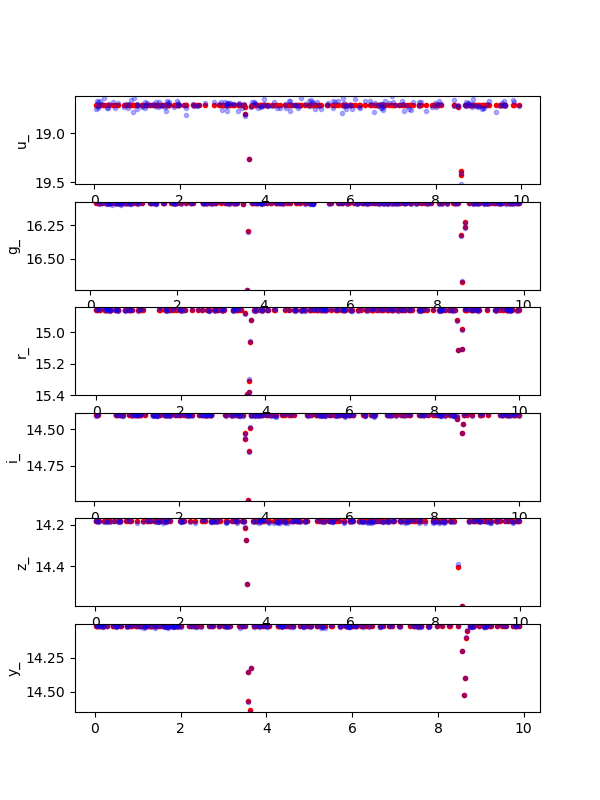

In [26]:
i=50
print(worker.useOpSimDates)
print(i)
L1 = 10.**df['logL'][i]
L2 = L1
r1 = 10.**df['logR'][i]
r2 = r1
dist = 10.**df['logDist'][i]
Av = df['Av'][i]
MH = df['[M/H]'][i]
#[m1, m2, logp, ecc, r1, r2, L1, L2, x,y,z, dist, inc, omega, Ab, MH]
line = [1., 1., 1., 0., r1, r2, L1, L2, 1., 1., 1., dist, np.pi/2., 0., 0., Av, MH]
EB = worker.getEB(line, i)

print(EB.period, EB.inclination, EB.R_1, EB.R_2, EB.sbratio, EB.q)

fig,ax = plt.subplots(6,1, figsize=(6,8))
for i,f in enumerate(worker.filters):
    EB.observe(f)

    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMag[f],'.', color='red')
    ax[i].plot((EB.obsDates[f] % EB.period), EB.appMagObs[f],'.', alpha=0.3, color='blue')
    ax[i].set_ylim(max(EB.appMagObs[f]), min(EB.appMagObs[f]))
    ax[i].set_ylabel(f)


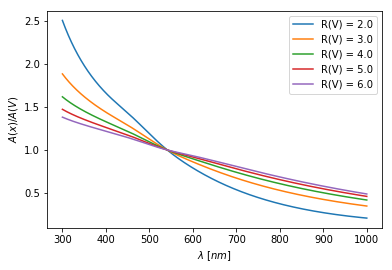

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from dust_extinction.parameter_averages import F04

fig, ax = plt.subplots()

# temp model to get the correct x range
text_model = F04()

# generate the curves and plot them
# x = np.arange(text_model.x_range[0],
#               text_model.x_range[1],0.1)/u.micron

x = np.arange(300,1000, 0.1 )*u.nm

Rvs = ['2.0','3.0','4.0','5.0','6.0']
for cur_Rv in Rvs:
    ext_model = F04(Rv=cur_Rv)
    ax.plot(x,ext_model(x),label='R(V) = ' + str(cur_Rv))

ax.set_xlabel('$\lambda$ [$nm$]')
ax.set_ylabel('$A(x)/A(V)$')

ax.legend(loc='best')
plt.show()

In [7]:
#https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/pyaslDoc/resBasedDoc/kuruczModels.html
#from PyAstronomy import pyasl
#running the command in the next cell for the first time, will download data
# The input is: Teff, logg, and log10(metallicity), but ... this doesn't give fluxes??
# model = pyasl.getKuruczModel(4250, 4.5, 0.0)
# print(model)
#f,ax = plt.subplot()

In [1]:
#https://pysynphot.readthedocs.io/en/latest/index.html#pysynphot-installation-setup
#need to download grid of models manually, and set path accordingly
from astropy.io import fits
import pysynphot as pyS

import os
#export PYSYN_CDBS=/my/local/dir/cdbs/
print(os.environ['PYSYN_CDBS'])

#Teff, M/H, logg
sp = pyS.Icat('ck04models', 5000, 0.12, 5.0)
print(sp.waveunits)
print(sp.fluxunits)
f,ax = plt.subplots()
ax.semilogx(sp.wave, sp.flux)#,'.')
#ax.set_xlim(3000, 4000)



/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


/Users/ageller/python_scripts/PySynphotData/
angstrom
flam


NameError: name 'plt' is not defined

In [9]:
print((constants.h * 1*units.Hz).cgs)

6.62607004e-27 erg


In [10]:
#pyS.reddening.print_red_laws()
pyS.Extinction(0.1, 'gal3')(10000)

0.890721221431598